In [391]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root

from simulation import *
from plotting import *

from joblib import Parallel, delayed

In [385]:
def solve_optimal(nbody_sol, masses, x0, v0, m0, xf, mf, **kwargs):
    y0 = np.concatenate([x0, v0, m0])
    
    n = len(masses)
    
    #todo make these params
    v_e = 2
    alpha = 1
    beta = 1
    tf_guess = 5
    t_steps = 5
    #G = 6.67430e-11
    
    def control_root(control, m, p):
        #m has shape (1,N)
        #p has shape (N, 5, 1)
        u, theta = control.reshape((2,-1))
        
        #p shape (N,5,1) -> (N,1,5)
        p = np.transpose(p, (0,2,1))

        #dfdfu shape (3,1,N) -> (N,3,1)
        #batch dot product with p[:,:,2:] shape (N,1,3)
        #-> (N,1,1)
        p_dfdu = p[:,:,2:]@np.transpose(np.stack([
            v_e/m * np.cos(theta),
            v_e/m * np.sin(theta),
            -np.ones_like(m)
        ]), (2,0,1))

        #shape (1,N)
        dldu = 2*alpha*v_e*u/m + 2*beta*u
        
        #df/dth shape (2, N)->(2, N, 1) -> (N, 2, 1)
        #batch dot product with p[:,:,2:4] shape (N, 1, 2)
        #-> (N,1,1)
        p_dfdth = p[:, :, 2:4]@np.transpose(
            np.expand_dims(v_e*u/m *np.stack([
            -np.sin(theta),
            np.cos(theta)
        ]), 2), (1, 0, 2))

        #return shape (2*N,)
        return np.concatenate([
            p_dfdu.flatten() + dldu.flatten(), #dH/du = 0
            p_dfdth.flatten() #dH/d theta = 0
        ])
    
    def ode(t, y, tf):
        N = len(t)
        #Unpack y after adjusting dimensions for batch matrix operations
        #y shape (10,N) -> (N,10) ->(N, 10, 1)
        y = np.expand_dims(y.T,2)
        #x shape (N,2,1)
        x = y[:, :2, :]
        #v shape (N,2,1)
        v = y[:, 2:4, :]
        #m shape (N, 1,1)
        m = y[:, 4:5, :]
        #p shape (N, 5, 1)
        p = y[:, 5:, :]

        batch_control_guess = np.random.random(2*N)#np.concatenate([np.ones(N), np.zeros(N)])
        #Solve for control. u and theta should both have shape (N,)
        u, theta = root(control_root, batch_control_guess, args=(m.reshape(1,-1),p)).x.reshape(2,-1)
        #reshape u to have batch shape (N, 1, 1)
        u = u.reshape(-1,1,1)
        #Create ang from theta with shape (N, 2, 1)
        ang = np.expand_dims(np.stack([
            np.cos(theta),
            np.sin(theta)
        ]).T, 2)
        
        #Create "batch" identity matrix of shape (N,2,2)
        I = np.stack([np.eye(2) for i in range(N)])
        
        #Find the acceleration and big_ugly
        grav_accel = np.zeros((N,2,1))
        big_ugly = np.zeros((N,2,2))
        
        #rs shape (6n, N) -> (N, 6n) -> (N, 6n, 1)
        rs = np.expand_dims(nbody_sol.sol(tf[0]*t).T,2)
        for i in range(n):
            r = rs[:,6*i: 6*i+2,:] #shape (N, 2, 1)
            rx = r - x #shape (N, 2, 1)
            dist_rx = np.linalg.norm(rx, axis=1, keepdims=True) #dist_rx shape (N,1,1)
            #if np.isclose(dist_rx, 0).any():
            #    print("i",i, dist_rx.squeeze(), x.squeeze())
            grav_accel += masses[i] * (rx)/dist_rx**3
        
            #we can't use np.outer() here for the outer product because it will flatten the input arrays
            #We want to do a batch outer product that uses batch matrix multiplication of the shapes
            #(N,2,1) and (N,1,2) returns a matrix of shape (N,2,2)
            rx_outer = rx@np.transpose(rx, (0,2,1))
            big_ugly += masses[i] * (-I + 3*rx_outer/dist_rx**2)/dist_rx**3
        
        u_accel = v_e*u/m * ang
        accel = u_accel + grav_accel #accel should have shape (N, 2, 1)
        
        #Costate evolution
        
        #costate shape = (N,5,5)@(N,5,1) = (N,5,1)
        costate = -np.block([
            [np.zeros((N,2,2)), I, np.zeros((N,2,1))],
            [big_ugly, np.zeros((N,2,2)), -u_accel/m],
            [np.zeros((N,1,5))]
        ])@p
        
        #Concatenate the arrays together on axis=1 and squeeze axis 2 (which is just size 1) to get
        #an array of shape (N,10). Finally we need to transpose this to match the input size (10, N)
        return tf[0]*np.concatenate([
            v, #x' = v
            accel,
            -u,
            costate
        ], axis=1).squeeze().T
    
    #Used to find control in bc(...)
    control_guess = np.array([1,0])
    
    #Since there are 11 unknowns, we need 11 boundary conditions
    #unknown state variables, 5 unknown costate, and
    #1 unknown parameter (the final time t_f)
    def bc(ya, yb, tf):
        #reshape m and p for the vectorized control_root function
        #(I had to vectorize it for the ode() function)
        m = yb[4].reshape(1,1)
        p = yb[5:].reshape(1,5,1)
        
        #Solve for control at t_f
        u, theta = root(control_root, control_guess, args=(m,p)).x.squeeze()
        
        #Hamiltonian at final time, H(t_f) = p dot f - L
        #find the acceleration due to control and gravity at t_f
        control_accel = v_e*u/mf*np.array([
            np.cos(theta), np.sin(theta)])
        
        grav_accel = np.zeros(2)
        rs = nbody_sol.sol(tf[0])
        for i in range(n):
            dist = rs[6*i:6*i+2] - yb[:2]
            dist3norm = np.linalg.norm(dist)**3
            grav_accel += (masses[i]*dist/dist3norm)
        
        pf =  yb[5:].dot(np.concatenate([
            yb[2:4], #y_2 = x'
            control_accel + grav_accel,
            -np.array([u])
        ]))
        
        #Lagrangian at t_f
        L = 1 + (alpha*v_e/mf + beta) * u**2
        
        return np.concatenate([
            ya[:5] - y0, #x(0) = 0, v(0) = x'(0) = v0, m(0) = m0
            #This condition comes from our Bolza cost functional
            #which places a cost on x(t_f)'s distance from our desired target
            yb[5:7] + 2*(yb[:2] - xf), #p(t_f) = - Dphi/Dy(t_f)
            yb[7:9], #x'(t_f) is free (we could do the condition above)
            np.array([(yb[4] - mf), #m(t_f) = mf Fixed final mass
            (pf - L)]), #H(t_f) = p(t_f) dot f(x(t_f), u(t_f), th(t_f)) - L(t_f)
        ])
    
    t = np.linspace(0, 1, t_steps)
    guess = np.random.random((10, t_steps))
    return solve_bvp(ode, bc, t, guess, p=[tf_guess], **kwargs)
        

In [389]:
def attempt_solve():
    # Set up initial conditions and parameters
    t0 = 0
    tf = 25
    init = np.array([1, 1, 0, # Position 1
                     -1, -1, 0, # Position 2
                     #0, 0, 0, # Position 3
                     .35, -.25, 0, # Velocity/Momentum 1
                     -.35, .25, 0, # Velocity/Momentum 2
                     #.3, -.3, 0, # Velocity 3 
                     ])

    # Solve the system
    sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000), dense_output=True)
    
    masses = np.ones(2)
    x0 = np.zeros(2)
    v0 = np.array([0.3, -0.3])
    m0 = np.array([2])
    target = np.array([0.1, 0.1])
    m_f = 0.1

    sol2 = solve_optimal(sol, masses, x0, v0, m0, target, m_f, verbose=2)
    return sol2

In [ ]:
processes = 15
sols = Parallel(n_jobs=processes)(delayed(attempt_solve)() for i in range(processes))

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.20e+02       9.78e+00           5              8       
       2          1.13e+05       4.98e+04          13             24       
       3          6.52e+05       1.74e+04          37             72       
       4          5.97e+06       6.81e+04          109            216      
       5          1.41e+08       1.37e+04          325           (648)     
Number of nodes is exceeded after iteration 5. 
Maximum relative residual: 1.41e+08 
Maximum boundary residual: 1.37e+04


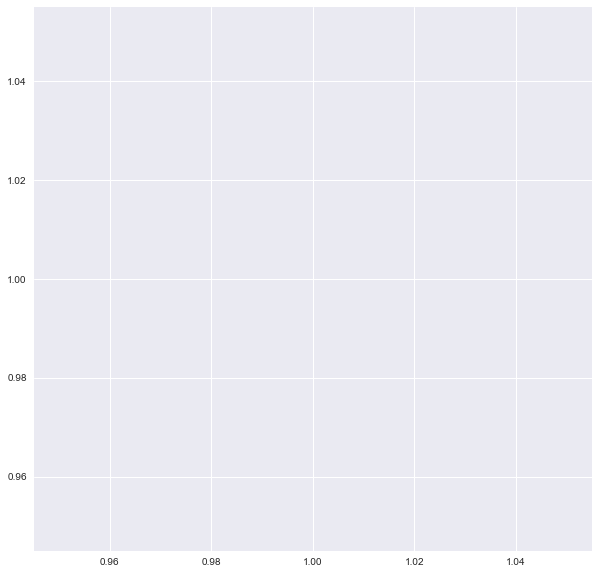

In [303]:
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[4], sol.y[5])
plt.plot(sol2.y[0], sol2.y[1])
plt.show()

In [191]:
#Test batched block matrices
A = np.ones((10,2,2))
b = np.ones((10,2,1))
C = np.ones((10,3,2))
d = np.ones((10,3,1))
np.block([
    [A, b],
    [C, d]
]).shape

(10, 5, 3)